In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from matplotlib import dates as mdates
plt.style.use('ggplot')
%matplotlib inline

import os
import re
import json
import urllib
import datetime

# custom module with helper functions

import bss_functions

In [2]:
import importlib
importlib.reload(bss_functions)

<module 'bss_functions' from '/Users/mariago/PycharmProjects/bss_project/bss_functions.py'>

In [3]:
def rel():
    importlib.reload(bss_functions)

In [4]:
rel()

### What kind of data would be useful for the prediction?
------------
- ID станции
- Временные признаки (выходной/праздник или нет, школьные каникулы, сезон)
- Погодные признаки (температура, идёт ли дождь, идёт ли снег, количество осадков, выпавших накануне)
- Тип станции по связанным с ней входящим и исходящим потокам в течение дня: (самобалансирующаяся станция, станция с исходящим потоком, станция со входящим потоком)
- Высота расположения станции над уровнем моря 
- Число велосипедов на станции вчера во время t и сегодня во время t-h
- Количество людей, живущих при этой станции (плотность населения $\ast$ площадь пересечения окружности с радиусом 300-500 метров и ячейки диаграммы Вороного) ?
- Максимальное число велосипедов на этой станции


### Data preparation

In [5]:
# Read data for the number of bikes at each station

data = pd.DataFrame()
n_obs = []
n_dropped = 0
for file_name in os.listdir('./data/')[:]:
    if 'bikes' in file_name:
        daily_obs = pd.read_csv('./data/' + file_name, index_col = 0)
        date = file_name.split('_')[1].split('.')[0]
        daily_obs.index = (pd.to_datetime(pd.Series(daily_obs.index).apply(lambda x: ' '.join([date, x]))))
        if len(daily_obs) > 700:
            n_obs.append(len(daily_obs))
            data = pd.concat([data, daily_obs],axis = 0)
        else:
            n_dropped += 1
n_obs = np.array(n_obs)
bss_functions.describe_data(data, 'data', n_obs, n_dropped)


    Collected data for:
              • 128 days without missing observations;
              • 60 days with 1 to 20 missing values.
    14 days with more than 20 missing values were dropped.

    The data covers the period from 24 January 2017 00:00 to 14 August 2017 00:00


In [6]:
# Delete the stations for which the data wasn't always available

del data['CHATHAM_STREET'], data['CLARENDON_ROW'], data['JAMES_STREET_EAST']

# Read coordinates of bicycle stations

stations = pd.read_csv('./data/station_locations.csv')
stations['Name'] = stations.Name.apply(lambda x: x.replace("'", ""))

# Calculate elevation of each station
# altitudes = [bss_functions.altitude(stations.Latitude[i], stations.Longitude[i]) for i in range(stations.shape[0])]

# Load pre-calculated elevation of each station

import pickle
f = open('./data/altitudes.dat', 'rb')
altitudes = pickle.load(f)
stations['Alt'] = altitudes

# Calculate capacity (the number of locks at each station)

capacity = pd.DataFrame({'Name': data.T.index.values, 'Capacity': data.max(0)})
capacity.Name = capacity.Name.apply(lambda x: x.replace('_', ' ').replace("'", ""))
stations = stations.merge(capacity, on = 'Name', how = 'inner')

# plot elevation of each station using custom function

bss_functions.plot_elevation_map(stations, stations.Latitude, stations.Longitude, stations.Name, stations.Alt)

#### Usage patterns: weekdays vs weekends

In [7]:
# Build up a time series of each station averaged over weekdays and weekends

df_copy = data.copy()
df_copy['weekday'] = df_copy.index.weekday
weekdays = df_copy.loc[df_copy['weekday'] < 5].drop(['weekday'], 1)
weekends = df_copy.loc[df_copy['weekday'] >= 5].drop(['weekday'], 1)

# Resample by 5 min and backfill nans

weekdays = weekdays.resample('5T').mean().bfill()
weekends = weekends.resample('5T').mean().bfill() 

# Group by minute of day and take average for each station

weekdays['time'] = weekdays.index.to_series().apply(lambda x: datetime.datetime.strftime(x, '%H:%M'))
weekdays = weekdays.groupby('time').agg('mean').astype(int)
weekends['time'] = weekends.index.to_series().apply(lambda x: datetime.datetime.strftime(x, '%H:%M'))
weekends = weekends.groupby('time').agg('mean').astype(int)

# Normalise each station between 0 and 1 as each station has different capacity
weekdays_norm = weekdays / weekdays.max()
weekends_norm = weekends / weekends.max()

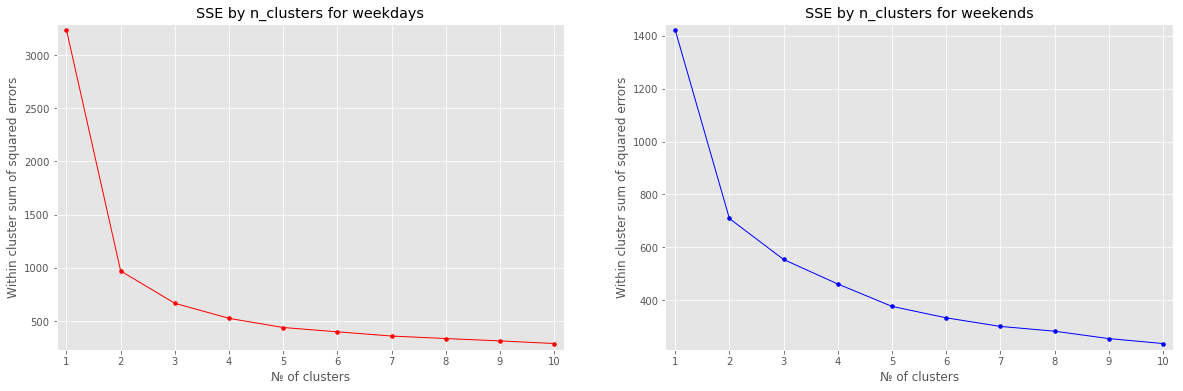

In [8]:
# Choose a suitable number of clusters using elbow method (mostly to support the intuition)
# 3 clusters can be selected both for the weekdays and weekends

bss_functions.plot_SSE(weekdays_norm, weekends_norm)

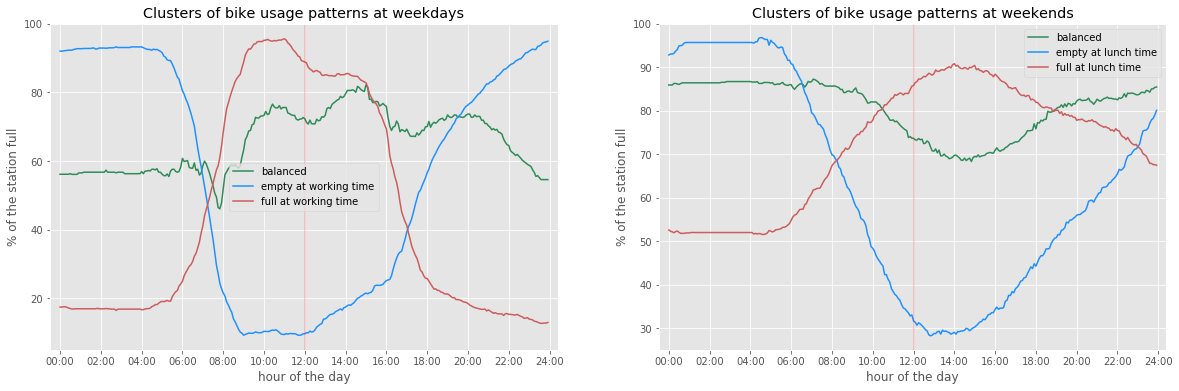

In [9]:
# K-means clustering to detect patterns in bike usage during weekdays and weekends
cluster_colours_wd = ['seagreen', 'dodgerblue', 'indianred']
cluster_colours_we = ['seagreen', 'dodgerblue', 'indianred']
clusters_weekdays, clusters_weekends = bss_functions.plot_cluster_usage_patterns(weekdays_norm, 
                                                                                 weekends_norm, 
                                                                                 cluster_colours_wd,
                                                                                 cluster_colours_we)

In [10]:
# Color stations based on their weekday usage pattern

folium_map = bss_functions.plot_clusters_map(stations, weekdays_norm, 
                                           clusters_array=clusters_weekdays, 
                                           cluster_colours=cluster_colours_wd)
folium_map.save('clusters_wd_map.html')
folium_map

In [11]:
# Color stations based on their weekend usage pattern

folium_map_1 = bss_functions.plot_clusters_map(stations, weekends_norm, 
                                           clusters_array=clusters_weekends, 
                                           cluster_colours=cluster_colours_we)
folium_map_1.save('clusters_we_map.html')
folium_map_1

In [12]:
# Read data collected from weather.com

weather = pd.DataFrame()
n_obs = []
n_dropped = 0
for file_name in os.listdir('./data/')[:]:
    if 'weather' in file_name:
        daily_obs = pd.read_csv('./data/' + file_name, index_col = 0)
        date = file_name.split('_')[1].split('.')[0]
        daily_obs.index = (pd.to_datetime(pd.Series(daily_obs.index).apply(lambda x: ' '.join([date, x]))))
        if len(daily_obs) > 700:
            n_obs.append(len(daily_obs))
            weather = pd.concat([weather, daily_obs],axis = 0)
        else:
            n_dropped += 1
n_obs = np.array(n_obs)
bss_functions.describe_data(weather, 'weather data', n_obs, n_dropped)


    Collected weather data for:
              • 128 days without missing observations;
              • 60 days with 1 to 20 missing values.
    14 days with more than 20 missing values were dropped.

    The data covers the period from 24 January 2017 00:00 to 14 August 2017 00:00


In [13]:
# Feature engineering

# Create dummy features from text description of the weather, then add intensity factor

weather = bss_functions.get_weather_features(weather)

# Resample by 1 min and interpolate with mean

features = pd.DataFrame({'Temperature': weather.resample('1T')['Temperature'].mean().interpolate(),
                          'Feels_Like': weather.resample('1T')['Feels_Like'].mean().interpolate(),
                          'Wind_Speed': weather.resample('1T')['Wind_Speed'].mean().interpolate(),
                          'Snow': weather.resample('1T')['Snow'].mean().interpolate(),
                          'Rain': weather.resample('1T')['Rain'].mean().interpolate(),  
                          'Clouds': weather.resample('1T')['Clouds'].mean().interpolate(),
                          'Fog': weather.resample('1T')['Fog'].mean().interpolate(),
                          'Thunder': weather.resample('1T')['Thunder'].mean().interpolate(),
                          'Hail': weather.resample('1T')['Hail'].mean().interpolate(), 
                                })

# Add categorical variable denoting month and dummy variables denoting season

features = bss_functions.get_seasonal_features(features)
features.head(3)

,Clouds,Feels_Like,Fog,Hail,Rain,Snow,Temperature,Thunder,Wind_Speed,Month,Spring,Summer,Winter
Time,,,,,,,,,,,,,
2017-01-24 00:00:00,1.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,24.0,1,0,0,1
2017-01-24 00:01:00,1.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,24.0,1,0,0,1
2017-01-24 00:02:00,1.0,3.0,0.0,0.0,0.0,0.0,7.0,0.0,24.0,1,0,0,1


ID станции
Временные признаки (выходной/праздник или нет, школьные каникулы, сезон)
Погодные признаки (температура, идёт ли дождь, идёт ли снег, количество осадков, выпавших накануне)
Тип станции по связанным с ней входящим и исходящим потокам в течение дня: (самобалансирующаяся станция, станция с исходящим потоком, станция со входящим потоком)
Высота расположения станции над уровнем моря
Число велосипедов на станции вчера во время t и сегодня во время t-h
Количество людей, живущих при этой станции (плотность населения  ∗
  площадь пересечения окружности с радиусом 300-500 метров и ячейки диаграммы Вороного) ?
Максимальное число велосипедов на этой станции

Надо:

- проверить, что нормально заполняются средним значения по погоде для дней, где этих значений мало. Может быть, выкинуть эти дни лучше. **CHECK**
- перегруппировать по минуте дейту, тоже проверить, что норм всё интерполируется **CHECK**
- сделать признаки "вчера во время предсказания", "сегодня сейчас", "сегодня сейчас минус эн?", "капасити станции"?
- высота над уровнем моря, каникулы, праздники
- викенд/викдей, добавить праздники!
- кластер станции?
- если отдельно для разных станций, то мб капасити и не нужно.
- вообще главное -- разобраться с этими departure и arrival rates, посчитать их для моих данных
- придумать какой-то алгоритм. Будни и выхи отдельно. Для каждой станции идём по каждому времени окном, и если в этом окне есть достаточно большой пик, то его берём и для него считаем arr rate / dep rate. Получаем для каждого окна времени много, но не data.shape[0] наблюдений рейтов. Берём их моду. Рейт считается не по ширине окна, а по ширине пика. 
- потом построить модели с лимитом по станциям, модели для моих "безлимитных" станций, сравнить их по кастомной метрике только на промежутках с наблюдаемым количеством велосипедов
- потом как-то определить, с какой точностью вообще я правильно лишний спрос посчитала?

- для текста график, показывающий, что на станциях частенько превышен лимит ** CHECK **

- ТЕКСТ!!!!

In [303]:
data1 = data.resample('2H').last().bfill()

In [122]:
ys = data.resample('2H').last().bfill()

### Training models

In [21]:
from sklearn.linear_model import RidgeCV, LassoCV
from sklearn.model_selection import train_test_split
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

def model_report(model, X_train, y_train, X_test, y_test, best_alpha = False):
    model_fit = model.fit(X_train, y_train)
    train_pred = model_fit.predict(X_train)
    test_pred = model_fit.predict(X_test)
    print("MSE train:", mean_squared_error(y_train, train_pred))
    print("R^2 train",r2_score(y_train, train_pred))
    print("MSE test:",mean_squared_error(y_test, test_pred))
    print("R^2 test:",r2_score(y_test, test_pred))
    if best_alpha:
        print("Best alpha:", model_fit.alpha_)

In [23]:
X = features.resample('2H').mean()
y = data['BOLTON_STREET'].resample('2H').last().bfill()
#y_lag = [[0]]
#y_lag.append([x for x in y[1:].values]) нужно же для каждого дня своё, а не просто шифт на 1
#X['y_lag'] = [x for subset in y_lag for x in subset ]

In [24]:
svr = SVR(kernel = 'rbf')
ridge = RidgeCV(alphas = [0.5, 0.9, 1])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
preds = svr.fit(X_train, y_train).predict(X_test)

In [25]:
from sklearn.metrics import mean_squared_error

In [26]:
model_report(svr, X_train, y_train, X_test, y_test)

MSE train: 34.10004330898632
R^2 train 0.06761126584434851
MSE test: 35.35304338727514
R^2 test: -0.011078660152864739


In [27]:
model_report(ridge, X_train, y_train, X_test, y_test)

MSE train: 35.529846445463036
R^2 train 0.02851652556992823
MSE test: 34.008153143869286
R^2 test: 0.027384501574390874


In [28]:
import missingno as msno
msno.matrix(df.iloc[:,:34])

NameError: name 'df' is not defined

In [29]:
msno.matrix(df.iloc[:,34:-34])

NameError: name 'df' is not defined

In [30]:
msno.matrix(df.iloc[:,-34:])

NameError: name 'df' is not defined

In [31]:
for date_ in df.DATE.unique():
    date = df[df.DATE == date_].values
    
lst = df[df.DATE == datetime.date(2017, 2, 14)]['BLESSINGTON_STREET'].values
flow = np.empty(len(lst)-1)
for i in range(len(lst)-1):
    flow[i] = lst[i+1] - lst[i]
#flow = np.array(flow)

NameError: name 'df' is not defined

In [ ]:
for i in range(df.shape[1]-1):
    station = df.iloc[:, i]
    for date_ in df.DATE.unique():
    date = df[df.DATE == date_].values
    
    

In [ ]:
station[station.index == '2017-02-15']

In [89]:
xticks = range(0, 720, 24)
xticks_labels = ["%02d:%02d" % divmod(i, 60) for i in [int(tick) for tick in xticks]]
xticks_labels[:5]

['00:00', '00:24', '00:48', '01:12', '01:36']

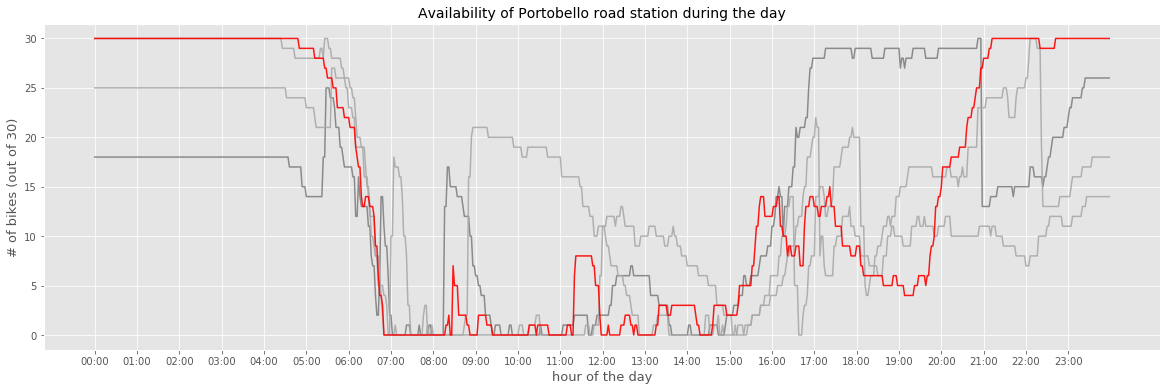

In [19]:
data['DATE'] = [x.date() for x in data.index]
df_copy = data.copy()
df_copy['weekday'] = df_copy.index.weekday
weekdays = df_copy.loc[df_copy['weekday'] < 5].drop(['weekday'], 1)

range_ = [12, 11, 21]#range(21, 23)
colors = ['grey', 'darkgrey', 'red']
figure, axis_weekdays = plt.subplots(1, 1, figsize=(20, 6))
for x, col in zip(range_, colors):
    for y in [8, 7]:       
        axis_weekdays.plot(weekdays[weekdays.DATE == datetime.date(2017, y, x)]['PORTOBELLO_ROAD'].values, color = col, alpha = 0.9)
xticks = axis_weekdays.get_xticks()
xticks = range(0, 720, 30)
xticks_labels = ["%02d:%02d" % divmod(i*2, 60) for i in [int(tick) for tick in xticks]]
axis_weekdays.set_xticks(xticks)
axis_weekdays.set_xticklabels(xticks_labels)
axis_weekdays.tick_params(axis = 'both', labelsize = 10)

plt.ylabel('# of bikes (out of 30)')
plt.xlabel('hour of the day')
axis_weekdays.xaxis.label.set_fontsize(13)
axis_weekdays.yaxis.label.set_fontsize(13)

plt.title('Availability of Portobello road station during the day')
axis_weekdays.title.set_fontsize(14)


plt.show()

In [71]:
[x for x in range(5,6)]

[5]

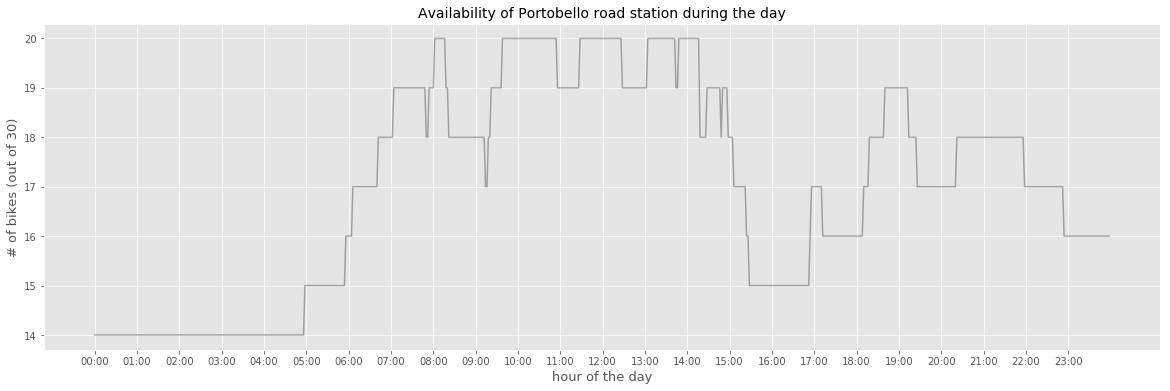

In [70]:
range_ = range(5,6)
colors = ['black']#['grey', 'darkgrey', 'red']
figure, axis_weekdays = plt.subplots(1, 1, figsize=(20, 6))
for x, col in zip(range_, colors*len(range_)):
    for y in [6]:       
        axis_weekdays.plot(weekdays[weekdays.DATE == datetime.date(2017, y, x)]['MERRION_SQUARE_WEST'].values, alpha = 0.3, color = col)
xticks = axis_weekdays.get_xticks()
xticks = range(0, 720, 30)
xticks_labels = ["%02d:%02d" % divmod(i*2, 60) for i in [int(tick) for tick in xticks]]
axis_weekdays.set_xticks(xticks)
axis_weekdays.set_xticklabels(xticks_labels)
axis_weekdays.tick_params(axis = 'both', labelsize = 10)

plt.ylabel('# of bikes (out of 30)')
plt.xlabel('hour of the day')
axis_weekdays.xaxis.label.set_fontsize(13)
axis_weekdays.yaxis.label.set_fontsize(13)

plt.title('Availability of Portobello road station during the day')
axis_weekdays.title.set_fontsize(14)


plt.show()

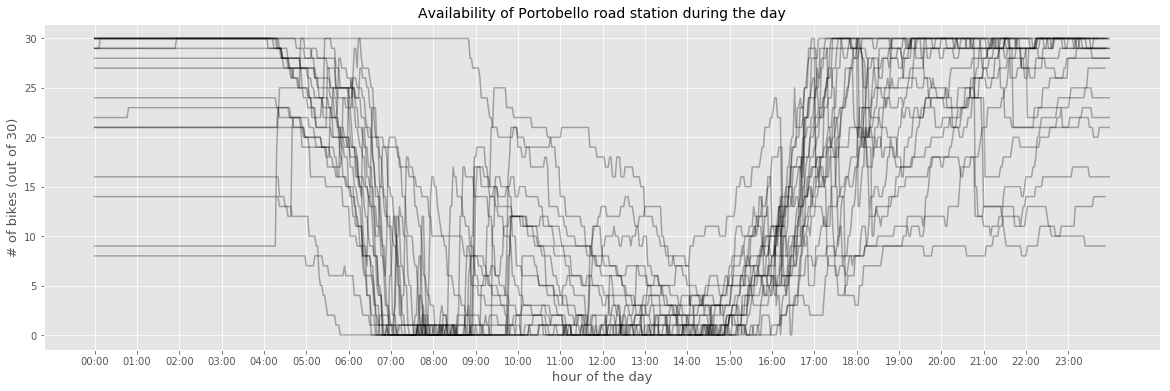

In [50]:
range_ = range(1, 10)
colors = ['black']#['grey', 'darkgrey', 'red']
figure, axis_weekdays = plt.subplots(1, 1, figsize=(20, 6))
for x, col in zip(range_, colors*len(range_)):
    for y in [8, 7, 6]:       
        axis_weekdays.plot(weekdays[weekdays.DATE == datetime.date(2017, y, x)]['PORTOBELLO_ROAD'].values, alpha = 0.3, color = col)
xticks = axis_weekdays.get_xticks()
xticks = range(0, 720, 30)
xticks_labels = ["%02d:%02d" % divmod(i*2, 60) for i in [int(tick) for tick in xticks]]
axis_weekdays.set_xticks(xticks)
axis_weekdays.set_xticklabels(xticks_labels)
axis_weekdays.tick_params(axis = 'both', labelsize = 10)

plt.ylabel('# of bikes (out of 30)')
plt.xlabel('hour of the day')
axis_weekdays.xaxis.label.set_fontsize(13)
axis_weekdays.yaxis.label.set_fontsize(13)

plt.title('Availability of Portobello road station during the day')
axis_weekdays.title.set_fontsize(14)


plt.show()

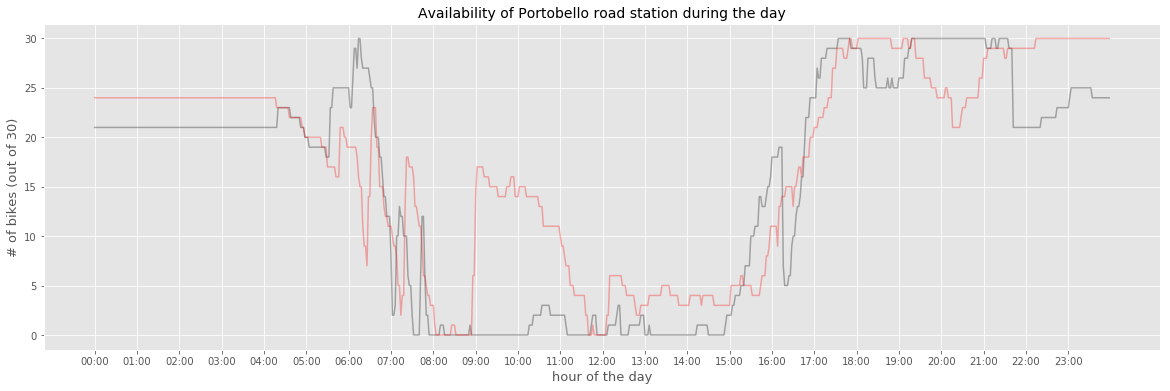

In [52]:
range_ = range(1, 3)
colors = ['black', 'red']#['grey', 'darkgrey', 'red']
figure, axis_weekdays = plt.subplots(1, 1, figsize=(20, 6))
for x, col in zip(range_, colors*len(range_)):
    for y in [8, 7]:       
        axis_weekdays.plot(weekdays[weekdays.DATE == datetime.date(2017, y, x)]['PORTOBELLO_ROAD'].values, alpha = 0.3, color = col)

for x, col in zip(range_, colors*len(range_)):
    for y in [8, 7]:       
        axis_weekdays.plot(weekdays[weekdays.DATE == datetime.date(2017, y, x)]['PORTOBELLO_ROAD'].values, alpha = 0.3, color = col)
        
xticks = axis_weekdays.get_xticks()
xticks = range(0, 720, 30)
xticks_labels = ["%02d:%02d" % divmod(i*2, 60) for i in [int(tick) for tick in xticks]]
axis_weekdays.set_xticks(xticks)
axis_weekdays.set_xticklabels(xticks_labels)
axis_weekdays.tick_params(axis = 'both', labelsize = 10)

plt.ylabel('# of bikes (out of 30)')
plt.xlabel('hour of the day')
axis_weekdays.xaxis.label.set_fontsize(13)
axis_weekdays.yaxis.label.set_fontsize(13)

plt.title('Availability of Portobello road station during the day')
axis_weekdays.title.set_fontsize(14)


plt.show()

In [ ]:
range_ = range(1, 10)
colors = ['black']#['grey', 'darkgrey', 'red']
figure, axis_weekdays = plt.subplots(1, 1, figsize=(20, 6))
for x, col in zip(range_, colors*len(range_)):
    for y in [8, 7]:       
        axis_weekdays.plot(weekdays[weekdays.DATE == datetime.date(2017, y, x)]['PORTOBELLO_ROAD'].values, alpha = 0.3, color = col)
xticks = axis_weekdays.get_xticks()
xticks = range(0, 720, 30)
xticks_labels = ["%02d:%02d" % divmod(i*2, 60) for i in [int(tick) for tick in xticks]]
axis_weekdays.set_xticks(xticks)
axis_weekdays.set_xticklabels(xticks_labels)
axis_weekdays.tick_params(axis = 'both', labelsize = 10)

plt.ylabel('# of bikes (out of 30)')
plt.xlabel('hour of the day')
axis_weekdays.xaxis.label.set_fontsize(13)
axis_weekdays.yaxis.label.set_fontsize(13)

plt.title('Availability of Portobello road station during the day')
axis_weekdays.title.set_fontsize(14)


plt.show()

In [37]:
weekdays['PORTOBELLO_ROAD'][weekdays.DATE == datetime.date(2017, 7, 14)][255:]

2017-07-14 08:30:09     0
2017-07-14 08:32:08     0
2017-07-14 08:34:09     0
2017-07-14 08:36:09     0
2017-07-14 08:38:08     0
2017-07-14 08:40:09     0
2017-07-14 08:42:09     0
2017-07-14 08:44:08     0
2017-07-14 08:46:09     0
2017-07-14 08:48:09     0
2017-07-14 08:50:09     0
2017-07-14 08:52:08     0
2017-07-14 08:54:09     0
2017-07-14 08:56:09     0
2017-07-14 08:58:09     0
2017-07-14 09:00:08     0
2017-07-14 09:02:09     0
2017-07-14 09:04:09     0
2017-07-14 09:06:08     1
2017-07-14 09:08:09     1
2017-07-14 09:10:09     1
2017-07-14 09:12:08     1
2017-07-14 09:14:09     1
2017-07-14 09:16:09     1
2017-07-14 09:18:08     1
2017-07-14 09:20:09     1
2017-07-14 09:22:09     1
2017-07-14 09:24:08     1
2017-07-14 09:26:09     1
2017-07-14 09:28:08     1
                       ..
2017-07-14 23:00:09    18
2017-07-14 23:02:09    18
2017-07-14 23:04:08    18
2017-07-14 23:06:09    18
2017-07-14 23:08:09    19
2017-07-14 23:10:09    19
2017-07-14 23:12:08    20
2017-07-14 2

In [535]:
data['DATE'] = [x.date() for x in data.index]
data.columns = [x.replace("'",'') for x in data.columns.values]
dates = []
station_was_empty_3by2mins = []
station_was_full_3by2mins = []
for day in data.DATE.unique():
    dates.append(day)
    df_day = data[data.DATE == day]
    counter_stations_full = 0
    counter_stations_empty = 0
    for name, capacity in zip(stations.Name, stations.Capacity):
        if df_day[name.replace(' ', '_')][df_day[name.replace(' ', '_')] == capacity].shape[0] > 45:
            counter_stations_full += 1
        if df_day[name.replace(' ', '_')][df_day[name.replace(' ', '_')] == 0].shape[0] > 45:
            counter_stations_empty += 1
    station_was_full_3by2mins.append(counter_stations_full)
    station_was_empty_3by2mins.append(counter_stations_empty)   

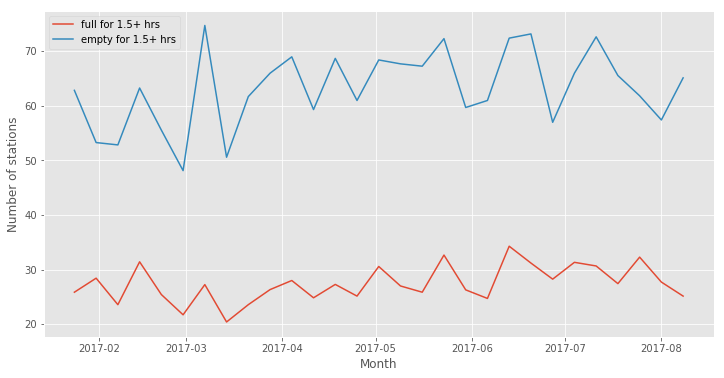

In [539]:
dff = pd.DataFrame({'full': station_was_full_3by2mins, 'empty': station_was_empty_3by2mins})
dff.index = pd.DatetimeIndex(dates)
dff = dff.sort_index(ascending=True)
dff['weekday'] = [x.weekday() for x in dff.index]
dff_week = dff[dff.weekday < 5]
dff_weekend = dff[dff.weekday >= 5]
dff = dff.resample('7D').mean().bfill()

fig = plt.figure(figsize=(12, 6))
plt.plot(dff['full'])
plt.plot(dff['empty'])
plt.legend(labels = ['full for 1.5+ hrs', 'empty for 1.5+ hrs'])
plt.xlabel('Month')
plt.ylabel('Number of stations')
fig.savefig('empty_full.png');

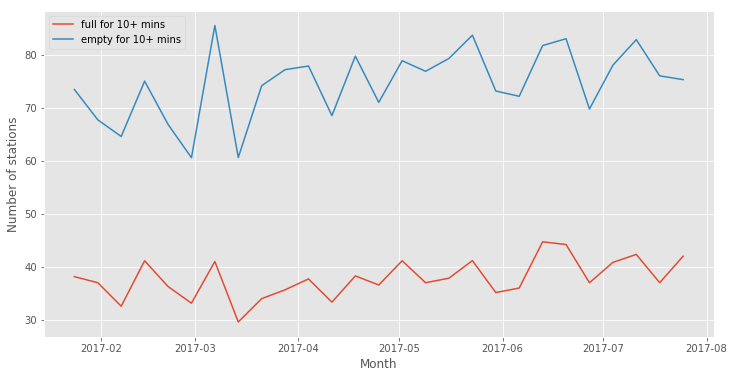

In [508]:
fig = plt.figure(figsize=(12, 6))
plt.plot(dff['full'][:-2])
plt.plot(dff['empty'][:-2])
plt.legend(labels = ['full for 10+ mins', 'empty for 10+ mins'])
plt.xlabel('Month')
plt.title('# of stations ')
plt.ylabel('Number of stations')
fig.savefig('empty_full.png');

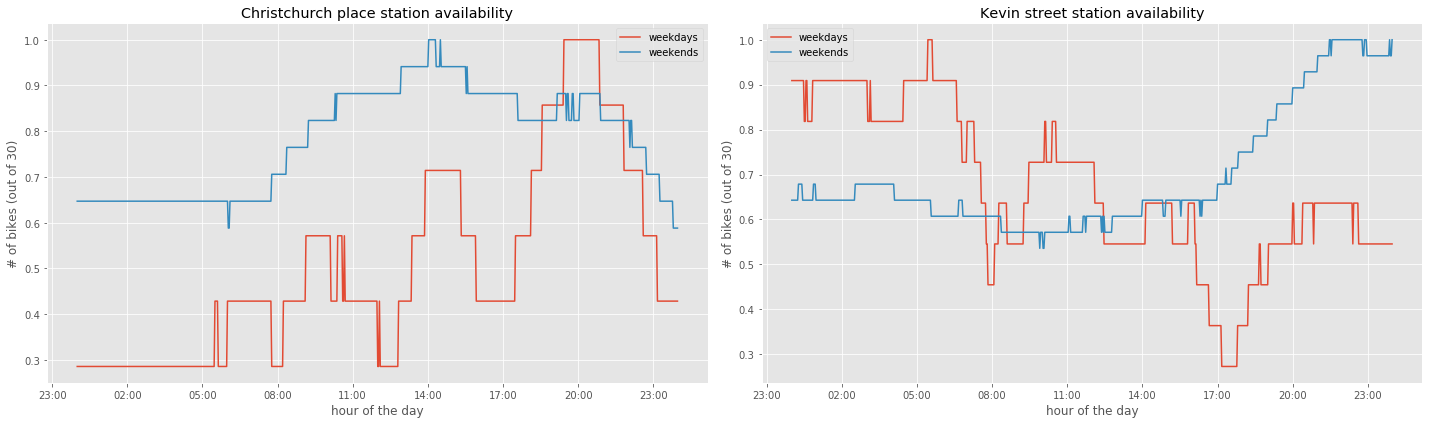

In [549]:
# CHRISTCHURCH_PLACE: tourist attractions nearby (Christ Church cathedral, Dublin Castle, Radisson Blu hotel)
# KEVIN_STREET: Dublin Institute of Technology

bss_functions.plot_usage_examples(data, 'CHRISTCHURCH_PLACE', 'KEVIN_STREET')

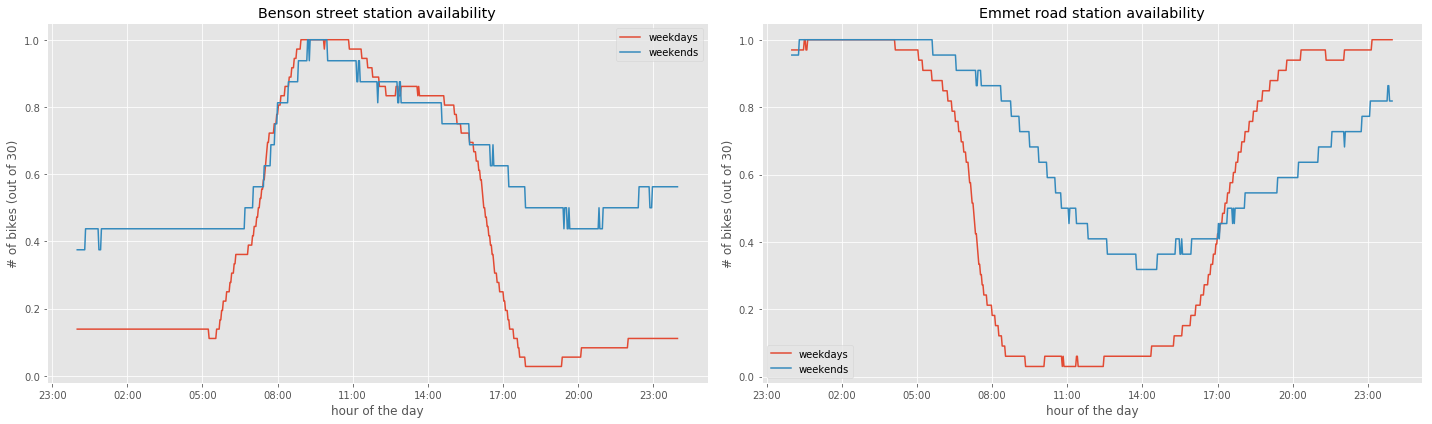

In [550]:
# BENSON_STREET: near the U2 tower; working sat and sun too so no shift
# EMMET_ROAD: outskirts of the city

bss_functions.plot_usage_examples(data, 'BENSON_STREET', 'EMMET_ROAD')